In [1]:
# %% 라이브러리 및 설정 불러오기
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# 한글 폰트 설정 (Windows: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# %% 데이터 파일 경로 및 파일명 설정
base_path = r"C:\Users\hyunj\Traffic\dataset"
# 불법 단속 현황 CSV (단속일시, 단속장소 등 포함)
illegal_file = "서울특별시 광진구_주정차단속현황_20250310.csv"
# 기존 CCTV 위치 정보 CSV (단속지점명 등 포함)
cctv_file = "서울시 광진구 불법주정차 위반 단속 CCTV 위치정보.csv"
# 추가 특성 데이터 CSV들 (예: 도심, 시계, 요일별, 월별)
city_file = "csv_output/도심.csv"
clock_file = "csv_output/시계.csv"
weekday_file = "csv_output/요일별.csv"
month_file = "csv_output/월별.csv"

In [3]:
# %% CSV 파일 로드 (인코딩: cp949)
try:
	illegal_df = pd.read_csv(os.path.join(base_path, illegal_file), encoding='cp949')
	cctv_df = pd.read_csv(os.path.join(base_path, cctv_file), encoding='cp949')
	city_df = pd.read_csv(os.path.join(base_path, city_file), encoding='cp949')
	clock_df = pd.read_csv(os.path.join(base_path, clock_file), encoding='cp949')
	weekday_df = pd.read_csv(os.path.join(base_path, weekday_file), encoding='cp949')
	month_df = pd.read_csv(os.path.join(base_path, month_file), encoding='cp949')
except FileNotFoundError as e:
	print(f"파일을 찾을 수 없습니다: {e.filename}")
	# 필요한 경우, 대체 동작을 추가하세요 (예: 빈 DataFrame 생성)
	if '도심.csv' in str(e):
		city_df = pd.DataFrame(columns=['단속장소', '도심교통량'])
	elif '시계.csv' in str(e):
		clock_df = pd.DataFrame(columns=['단속장소', '시계교통량'])
	elif '요일별.csv' in str(e):
		weekday_df = pd.DataFrame(columns=['단속장소', '요일특성'])
	elif '월별.csv' in str(e):
		month_df = pd.DataFrame(columns=['단속장소', '월별특성'])
	else:
		raise


In [4]:
# %% 불법 주정차 단속 데이터 전처리
# '단속일시'를 datetime 형식으로 변환하고, 결측치 제거
illegal_df['단속일시'] = pd.to_datetime(illegal_df['단속일시'], errors='coerce')
illegal_df = illegal_df.dropna(subset=['단속일시'])
# 단속장소별 불법 건수 집계
illegal_counts = illegal_df['단속장소'].dropna() \
    .value_counts() \
    .rename_axis('단속장소') \
    .reset_index(name='불법건수')


In [5]:
# %% CCTV 데이터 전처리
# '단속지점명'을 기준으로 기존 CCTV 설치 건수 집계
cctv_counts = cctv_df['단속지점명'].dropna() \
    .value_counts() \
    .rename_axis('단속장소') \
    .reset_index(name='CCTV수')

In [6]:
# 각 CSV가 단속장소 기준으로 특성을 제공한다고 가정합니다.
# (실제 컬럼명이 다르다면 적절히 수정하세요.)
# 예시로, 도심.csv는 ['단속장소', '도심교통량'] 컬럼을,
# 시계.csv는 ['단속장소', '시계교통량'] 컬럼을,
# 요일별.csv는 ['단속장소', '요일특성'] 컬럼을,
# 월별.csv는 ['단속장소', '월별특성'] 컬럼을 가지고 있다고 가정합니다.
if '도심교통량' not in city_df.columns:
    city_df.rename(columns={city_df.columns[1]: '도심교통량'}, inplace=True)
if '시계교통량' not in clock_df.columns:
    clock_df.rename(columns={clock_df.columns[1]: '시계교통량'}, inplace=True)
if '요일특성' not in weekday_df.columns:
    weekday_df.rename(columns={weekday_df.columns[1]: '요일특성'}, inplace=True)
if '월별특성' not in month_df.columns:
    month_df.rename(columns={month_df.columns[1]: '월별특성'}, inplace=True)

In [7]:
# %% 데이터 통합
# '단속장소' 컬럼이 있는지 확인하고, 없으면 생성 또는 이름 변경
if '단속장소' not in illegal_counts.columns:
    illegal_counts.rename(columns={illegal_counts.columns[0]: '단속장소'}, inplace=True)
if '단속장소' not in cctv_counts.columns:
    cctv_counts.rename(columns={cctv_counts.columns[0]: '단속장소'}, inplace=True)
if '단속장소' not in city_df.columns:
    city_df.rename(columns={city_df.columns[0]: '단속장소'}, inplace=True)
if '단속장소' not in clock_df.columns:
    clock_df.rename(columns={clock_df.columns[0]: '단속장소'}, inplace=True)
if '단속장소' not in weekday_df.columns:
    weekday_df.rename(columns={weekday_df.columns[0]: '단속장소'}, inplace=True)
if '단속장소' not in month_df.columns:
    month_df.rename(columns={month_df.columns[0]: '단속장소'}, inplace=True)

# 불법 단속 건수와 기존 CCTV 설치 건수를 단속장소 기준으로 병합
data = illegal_counts.merge(cctv_counts, on='단속장소', how='left')
# 기타 특성 데이터 병합
data = data.merge(city_df[['단속장소', '도심교통량']], on='단속장소', how='left')
data = data.merge(clock_df[['단속장소', '시계교통량']], on='단속장소', how='left')
data = data.merge(weekday_df[['단속장소', '요일특성']], on='단속장소', how='left')
data = data.merge(month_df[['단속장소', '월별특성']], on='단속장소', how='left')

# 결측치는 적절한 값으로 대체 (CCTV는 없으면 0, 기타는 중앙값 사용)
data['CCTV수'] = data['CCTV수'].fillna(0)
for col in ['도심교통량', '시계교통량', '요일특성', '월별특성']:
    data[col] = data[col].fillna(data[col].median())

c:\Users\hyunj\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\hyunj\AppData\Local\Temp\ipykernel_15396\2137162059.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].fillna(data[col].median())
c:\Users\hyunj\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\hyunj\AppData\Local\Temp\ipykernel_15396\2137162059.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd

In [8]:
# %% 파생 변수 생성 및 타겟 변수 정의
# 불법 건수 대비 기존 CCTV 설치 비율 계산
# CCTV가 0인 경우 불법 건수를 그대로 사용하도록 함 (즉, 비율이 높아짐)
data['불법_CCTV비율'] = data['불법건수'] / data['CCTV수'].replace(0, np.nan)
data['불법_CCTV비율'].fillna(data['불법건수'], inplace=True)

# 예시: 불법_CCTV비율이 중앙값보다 높으면 추가 CCTV 설치 필요성이 있다고 가정하여 타겟 변수 생성
threshold_ratio = data['불법_CCTV비율'].median()
data['설치필요'] = (data['불법_CCTV비율'] > threshold_ratio).astype(int)

print("통합 데이터 미리보기:\n", data.head())

통합 데이터 미리보기:
           단속장소   불법건수  CCTV수  도심교통량  시계교통량  요일특성  월별특성  불법_CCTV비율  설치필요
0        21398  64150    0.0    NaN    NaN   NaN   NaN    64150.0     1
1  지너스타워 주차장 앞   9723    1.0    NaN    NaN   NaN   NaN     9723.0     1
2   리젠트오피스텔건너편   6865    1.0    NaN    NaN   NaN   NaN     6865.0     1
3      중곡지구대 앞   5678    1.0    NaN    NaN   NaN   NaN     5678.0     1
4  리젠트오피스텔 건너편   5054    0.0    NaN    NaN   NaN   NaN     5054.0     1


C:\Users\hyunj\AppData\Local\Temp\ipykernel_15396\1693389921.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['불법_CCTV비율'].fillna(data['불법건수'], inplace=True)


In [9]:
# 특징(feature)와 타겟(target) 분리
features = ['불법건수', 'CCTV수', '도심교통량', '시계교통량', '요일특성', '월별특성', '불법_CCTV비율']
X = data[features]
y = data['설치필요']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestClassifier를 이용한 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("모델 정확도:", accuracy)
print("모델 AUC:", auc)


모델 정확도: 1.0
모델 AUC: 1.0


In [10]:
# %% 전체 데이터에 대해 예측 및 추천
# 각 단속장소별로 추가 CCTV 설치 필요성 예측 확률 산출
data['예측설치필요확률'] = model.predict_proba(X)[:, 1]

# 예측 확률이 높은 순으로 정렬하여 상위 후보 도출
recommendations = data.sort_values(by='예측설치필요확률', ascending=False)
print("\n추가 CCTV 설치 추천 순위 (상위 10):")
print(recommendations[['단속장소', '예측설치필요확률']].head(10))


추가 CCTV 설치 추천 순위 (상위 10):
             단속장소  예측설치필요확률
0           21398       1.0
15166       성광교회앞       1.0
15054  아차산로78길153       1.0
15053       43191       1.0
15052       43221       1.0
15051       43252       1.0
15050       42675       1.0
15049       42644       1.0
15048      영화사로13       1.0
15047       42614       1.0


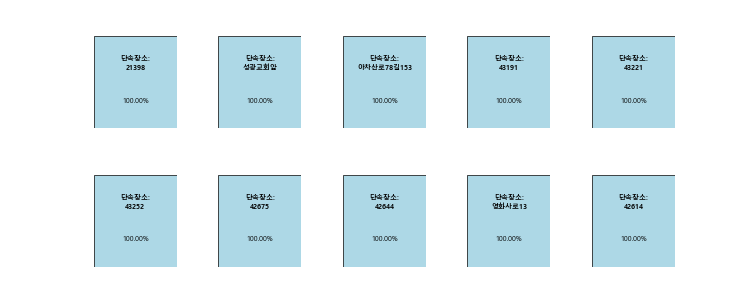

In [13]:
from matplotlib.patches import Rectangle
from IPython.display import Image, display

# 이미지 저장 경로
image_path = "cctv_recommendations_2x5.png"

# 상위 10개 추천 데이터 추출
top_recommendations = recommendations[['단속장소', '예측설치필요확률']].head(10).reset_index(drop=True)

# 카드 형식으로 시각화 (2x5 레이아웃)
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, (idx, row) in enumerate(top_recommendations.iterrows()):
    row_ax = ax[i // 5, i % 5]
    row_ax.axis('off')
    # 카드 배경
    row_ax.add_patch(Rectangle((0, 0), 1, 1, edgecolor='black', facecolor='lightblue', lw=1))
    # 단속장소 텍스트
    row_ax.text(0.5, 0.7, f"단속장소:\n{row['단속장소']}", fontsize=10, va='center', ha='center', weight='bold')
    # 설치 필요성 확률 텍스트
    row_ax.text(0.5, 0.3, f"{row['예측설치필요확률']:.2%}", fontsize=10, va='center', ha='center')

# 이미지 저장
plt.savefig(image_path, dpi=50)
plt.close()

# Jupyter Notebook에 이미지 표시
display(Image(filename=image_path))